In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow.keras.applications import resnet50
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import resnet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

## In this first part of the notebook, I will build a classification model to differentiate between faces with mask or without mask

In [2]:
# load the data from the disk
base_dir = os.path.join('dataset')
mask_dir = os.path.join(base_dir, 'with_mask')
nomask_dir = os.path.join(base_dir, 'without_mask')

mask_name = os.listdir(mask_dir)
nomask_name = os.listdir(nomask_dir)
mask_file = [os.path.join(mask_dir, name) for name in mask_name]
nomask_file = [os.path.join(nomask_dir, name) for name in nomask_name]

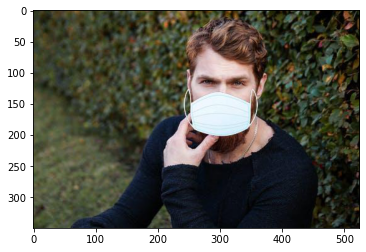

In [3]:
img = plt.imread(mask_file[0])
plt.imshow(img)

In [4]:
# building our data set, with masked images having label 1 and non-mask images having label 0
mask_file= np.array(mask_file)
nomask_file = np.array(nomask_file)

mask_y = np.ones(mask_file.shape)
nomask_y = np.zeros(nomask_file.shape)

X = np.concatenate((mask_file, nomask_file))
y = np.concatenate((mask_y, nomask_y))
# allocating 20% of the data to the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size = .2)

In [5]:
# this function performs the preprocessing on the images, so we can give them as input to our model
def preprocess(image_file):
    image_resized = load_img(image_file, target_size=(150, 150))
    image_resized = img_to_array(image_resized)
    image_final = resnet50.preprocess_input(image_resized)
    return image_final

In [6]:
train_img = np.array([preprocess(file) for file in X_train])
test_img = np.array([preprocess(file) for file in X_test])

batch_size = 32
# performing data augmentation using ImageDataGenerator in order to lower the risk of overfitting
train_datagen = ImageDataGenerator(rotation_range=40, width_shift_range = .2, height_shift_range=.2, shear_range=.2,
                                    zoom_range=.2, horizontal_flip = True, fill_mode = 'nearest')

train_generator = train_datagen.flow(train_img, y_train, batch_size = batch_size)

**The sceleton of the model consists of a resnet50, plus several fully connected layers on top of it**

In [7]:
# using resnet50 as a pretrained model and customize the top of the model to the specifics of this problem
pretrained_model = resnet50.ResNet50(input_shape = (150, 150, 3), weights='imagenet', include_top = False)
for layer in pretrained_model.layers:
    layer.trainable = False
    
last_layer = pretrained_model.get_layer('conv5_block3_out')
last_output = last_layer.output

x = keras.layers.Flatten()(last_output)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(.4)(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(.4)(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(.4)(x)
x = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(pretrained_model.input, x)

In [223]:
# compiling and training the model
optimizer = RMSprop(lr = 1e-4)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

history = model.fit(train_generator, steps_per_epoch = int(len(train_img)/batch_size)
                      , epochs = 10, validation_data = (test_img, y_test), validation_steps = int(len(test_img)/batch_size))

  ...
    to  
  ['...']
Train for 34 steps, validate on 276 samples
Epoch 1/10
34/34 [==============================] - 329s 10s/step - loss: 0.4275 - accuracy: 0.8006 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 2/10
34/34 [==============================] - 358s 11s/step - loss: 0.2037 - accuracy: 0.9185 - val_loss: 0.0055 - val_accuracy: 0.9961
Epoch 3/10
34/34 [==============================] - 332s 10s/step - loss: 0.1457 - accuracy: 0.9466 - val_loss: 0.0040 - val_accuracy: 0.9961
Epoch 4/10
34/34 [==============================] - 301s 9s/step - loss: 0.1227 - accuracy: 0.9522 - val_loss: 0.0193 - val_accuracy: 0.9922
Epoch 5/10
34/34 [==============================] - 278s 8s/step - loss: 0.1180 - accuracy: 0.9654 - val_loss: 0.0237 - val_accuracy: 0.9922
Epoch 6/10
34/34 [==============================] - 281s 8s/step - loss: 0.0718 - accuracy: 0.9728 - val_loss: 0.0219 - val_accuracy: 0.9922
Epoch 7/10
34/34 [==============================] - 275s 8s/step - loss: 0.0706 - 

**The model shows 0.98 accuracy on the training set and 1 accuracy on the validation set**

In [224]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

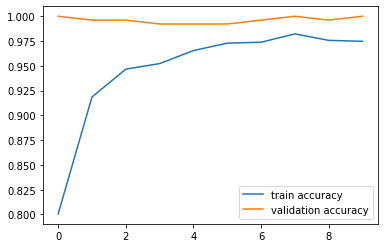

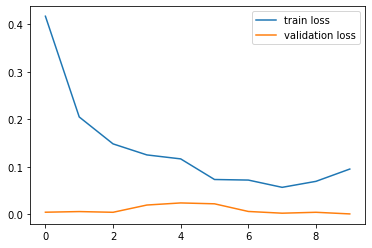

In [225]:
plt.plot(acc, label = 'train accuracy')
plt.plot(val_acc, label = 'validation accuracy')
plt.legend()

plt.figure()
plt.plot(loss, label = 'train loss')
plt.plot(val_loss, label = 'validation loss')
plt.legend()

## In this second part, I will define a Single Shot Detection (SSD) model and apply it using opencv, in order to detect the faces first

In [8]:
# loading two classification models
#model = keras.models.load_model('mask_model.h5')
model2 = keras.models.load_model('mask_model2.h5')
#model3 = keras.models.load_model('mask_model3.h5')

In [9]:
# loading the caffe model of face detection using
proto = r'face_detector\deploy.prototxt'
model_ssd = r'face_detector\res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNetFromCaffe(proto, model_ssd)

In [10]:
"""this function takes the boxes detected for the face mask, and filters out the ones
with probability lower than 0.5"""
def detection_box_filter(detections, w, h):
    boxes = []
    for i in range(detections.shape[2]):
        confidence = detections[:, :, i, 2]
        
        if confidence > .5:
            box = detections[0, 0, i, 3:7]*np.array([w, h, w, h])
            #startx, starty, endx, endy = box.astype('int')
            box = box.astype('int')
            boxes.append(box)
    return boxes

In [11]:
"""given the image and the model (in this case transfer learning from resnet50
with input_shape of (150, 150)) I use the faces detected with SSD algorithm in the previous step and
now I apply the classification model to see if each detected face wears mask or not"""

def detect(img, model):
    h, w = img.shape[:2]
    mean1, mean2, mean3 = img[:, :, 0].mean(), img[:, :, 1].mean(), img[:, :, 2].mean()
    # making blob from images and feeding it into our SSD face detection model
    blob = cv2.dnn.blobFromImage(img, 1, (300, 300)) #, (mean3, mean2, mean1))
    net.setInput(blob)
    detections = net.forward()
    boxes = detection_box_filter(detections, w, h)
    
    for box in boxes:
        x1, y1, x2, y2 = box
        # adding 60 pixels to each side of the region of interest (roi) so it contains the whole face
        roi = img[x1-60:x2+60, y1-60:y2+60, :]
        roi_reshaped = roi.reshape((1,) + roi.shape)
        roi_resized = tf.image.resize(roi_reshaped, [150, 150])
        roi_final = resnet50.preprocess_input(roi_resized)
        pred = model.predict(roi_final)
        # printing the text to the image, either it is "Mask" or "No Mask"
        if pred >=.5:
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3)
            cv2.putText(img, "Mask: {:.2f}%".format(pred[0][0]*100), (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, .6, (0, 255, 0), 2, cv2.LINE_AA)
        else:
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 3)
            cv2.putText(img, 'No Mask: {:.2f}%'.format((1 - pred[0][0])*100), (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, .6, (0, 0, 255), 2, cv2.LINE_AA)
    return img

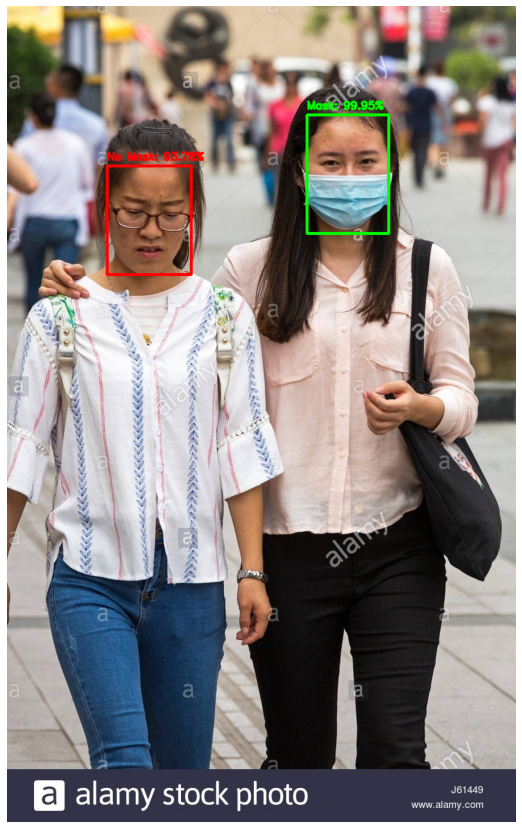

In [12]:
images = ['image ({}).jpg'.format(i) for i in range(1, 8)]
fig = plt.figure(figsize=(15, 15))
img = cv2.imread(images[3])
detected = detect(img, model2)
detected_rgb = cv2.cvtColor(detected, cv2.COLOR_BGR2RGB)
plt.imshow(detected_rgb)
_=plt.axis('off')

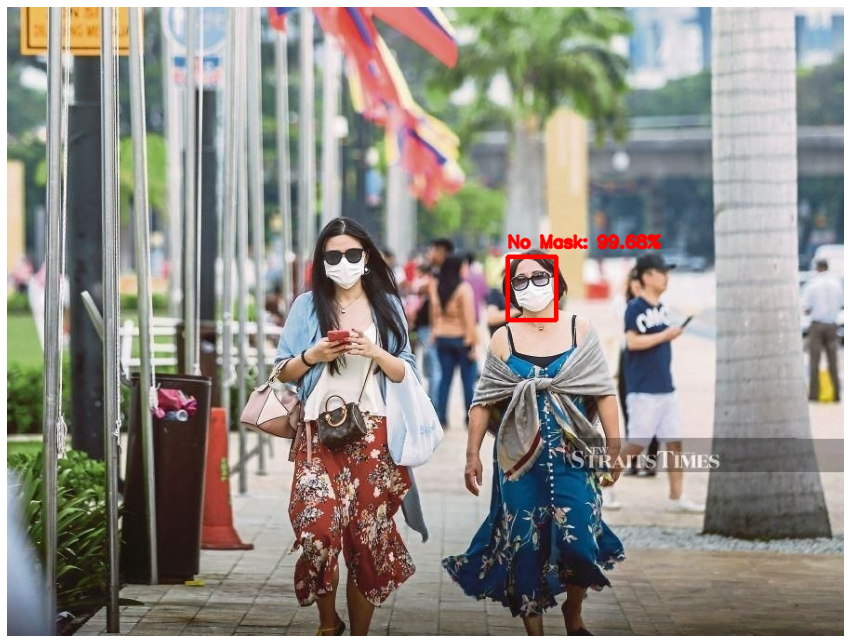

In [13]:
fig = plt.figure(figsize=(15, 15))
img = cv2.imread(images[2])
detected = detect(img, model2)
detected_rgb = cv2.cvtColor(detected, cv2.COLOR_BGR2RGB)
plt.imshow(detected_rgb)
_=plt.axis('off')

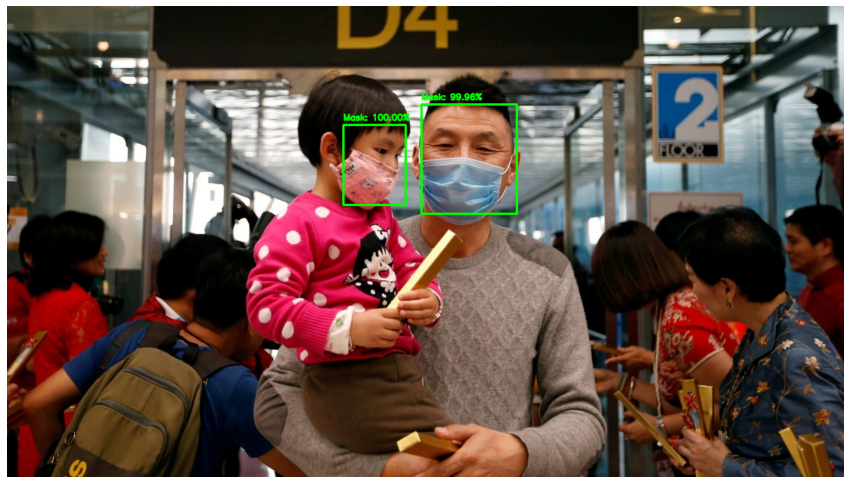

In [242]:
fig = plt.figure(figsize=(15, 15))
img = cv2.imread(images[1])
detected = detect(img, model2)
detected_rgb = cv2.cvtColor(detected, cv2.COLOR_BGR2RGB)
plt.imshow(detected_rgb)
_=plt.axis('off')

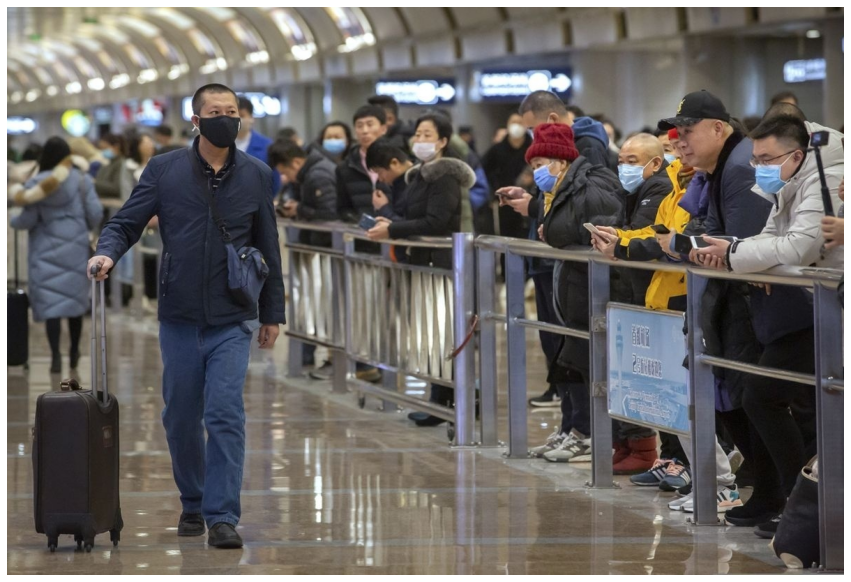

In [243]:
fig = plt.figure(figsize=(15, 15))
img = cv2.imread(images[4])
detected = detect(img, model2)
detected_rgb = cv2.cvtColor(detected, cv2.COLOR_BGR2RGB)
plt.imshow(detected_rgb)
_=plt.axis('off')

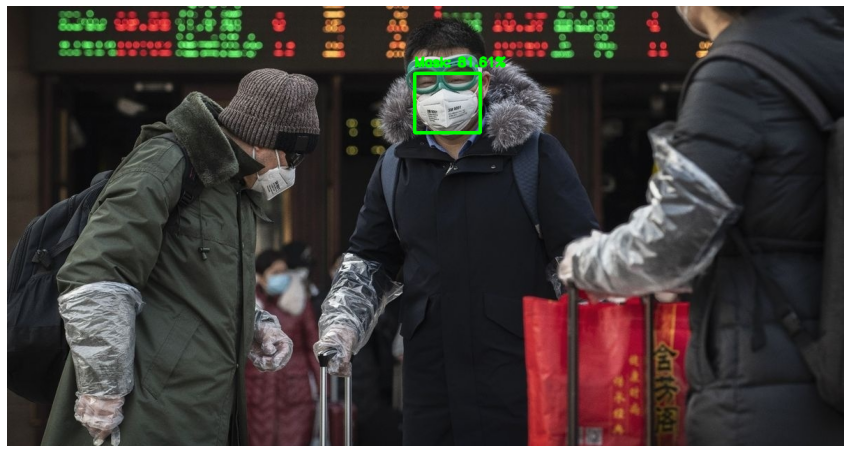

In [244]:
fig = plt.figure(figsize=(15, 15))
img = cv2.imread(images[0])
detected = detect(img, model2)
detected_rgb = cv2.cvtColor(detected, cv2.COLOR_BGR2RGB)
plt.imshow(detected_rgb)
_=plt.axis('off')

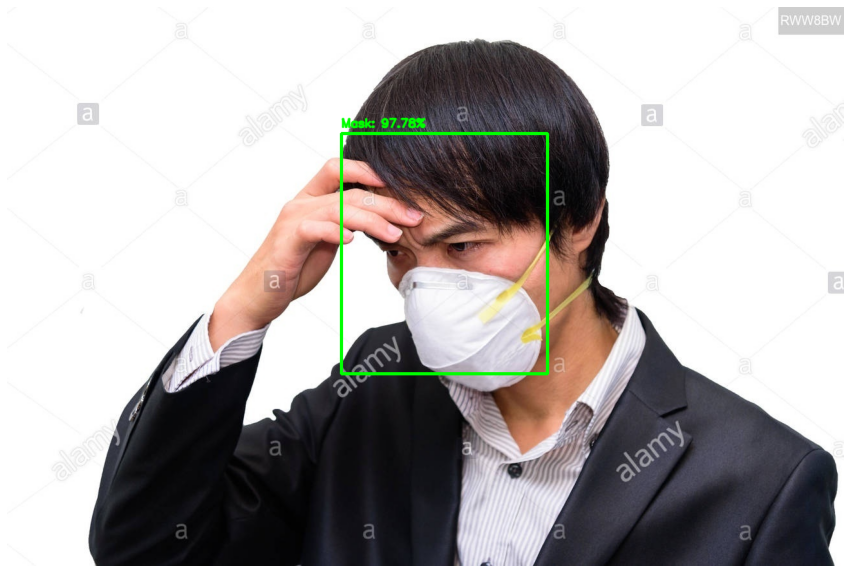

In [245]:
fig = plt.figure(figsize=(15, 15))
img = cv2.imread(images[5])
detected = detect(img, model2)
detected_rgb = cv2.cvtColor(detected, cv2.COLOR_BGR2RGB)
plt.imshow(detected_rgb)
_=plt.axis('off')

In [210]:
# capturing the video using opencv

cap = cv2.VideoCapture(0)
while True:
    _, frame = cap.read()
    canvas = detect(frame, model)
    cv2.imshow("canvas", canvas)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()